# Introduction

The following notebook is work-in-progress for the CORD-19-research-challenge on Kaggle.  
Our goal is to be able to search the dataset and find some answers to the tasks that are defined on Kaggle. We are usind mutiple embbeddings such as word2Vec or a simple td-idf on the papers.

## Dataset

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records  

# Setup

## Import packages

In [116]:
import pandas as pd
import numpy as np
import scipy as sc

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpld3
import mplcursors

import json
import os
import glob
import re
import warnings
import random
import spacy
from itertools import chain
from collections import  namedtuple
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec, doc2vec
from gensim.utils import simple_preprocess

from rank_bm25 import BM25Okapi

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

#from sentence-transformers import SentenceTransformer
import transformers

## Download the stopwords and special characters

In [2]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m_lev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m_lev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data processing

### Collect json files

In [3]:
# get all paths
filepath_biorxiv = '.data/biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = '.data/noncomm_use_subset/noncomm_use_subset'
filepath_comm = './data/comm_use_subset/comm_use_subset'
filepath_custom = '.data/custom_license/custom_license'

In [4]:
# enumerate json files
all_json_files = glob.glob(f'data/**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'data/biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'data/noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'data/comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'data/custom_license/**/*.json', recursive=True)

### Create dictionary
Create a dictionary with the plain texts, indexing all papers with it's ID, store dictionary as json

In [86]:
# read metadata.csv as panda df index by 'cord_uid'
metadata_df = pd.read_csv('data/metadata.csv', keep_default_na=False)

# convert the metadata to a dictionary
paper_dict = {}
for i in range(len(metadata_df)):
    # extract body text from json file if possible
    has_pdf_parse = metadata_df.iloc[i]['has_pdf_parse']
    if has_pdf_parse:
        full_text_file = metadata_df.iloc[i]['full_text_file']
        sha = metadata_df.iloc[i]['sha']

        json_file_glob = 'data/{0}/**/{1}.json'.format(full_text_file, sha)
        paper = glob.glob(json_file_glob, recursive=True)
        
        body_text = ''
        try:
            with open(os.path.join(paper[0])) as json_file:
                paper_json = json.load(json_file)
                body_text = concat_json_properties_as_string(paper_json['body_text'], 'text')
        except:
            pass
        
    # create dict
    paper_dict[metadata_df.iloc[i]['cord_uid']] = {
        'sha': sha,
        'title': metadata_df.iloc[i]['title'],
        'authors': metadata_df.iloc[i]['authors'],
        'abstract': metadata_df.iloc[i]['abstract'],
        'body_text': body_text,
        'publish_date': metadata_df.iloc[i]['publish_time'],
        'journal': metadata_df.iloc[i]['journal'],
        'url': metadata_df.iloc[i]['url'],
    }

# save dictionary to binary file  
save_obj(paper_dict, "paper_dict")

In [ ]:
# load dictionary from the binary file
paper_dict = load_obj("paper_dict")

## Helper functions

In [20]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [23]:
def preprocessing(text, additional_stopwords=[]):
    preprocessed_text = simple_preprocess(text)
    filtered_list = []
    for token in preprocessed_text:
      if token in stopwords.words('english') or token in additional_stopwords  or token.isnumeric():
          continue
      filtered_list.append(token)
    return filtered_list

In [24]:
def get_preprocessed_text_from_files(json_files, attribute):
  preprocessed_text = [] 
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
        
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        preprocessed_text_ = preprocessing(str(text))
        preprocessed_text.append(preprocessed_text_)
        
  return preprocessed_text

In [25]:
def get_preprocessed_text_from_dict(attribute):
    preprocessed_text = []
    for key in paper_dict:
        attribute_string = paper_dict[key][attribute]
        
        if (attribute_string != ''):
            preprocessed_text_ = preprocessing(attribute_string)
            preprocessed_text.append(preprocessed_text_)
        
    return preprocessed_text

In [26]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        try:
            text = concat_json_properties_as_string(json_object[attribute], 'text')
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        except:
            pass
        
  return preprocessed_tokenized_sentences

In [27]:
def get_preprocessed_sentences_from_dict(attribute):
    preprocessed_tokenized_sentences = []
    for key in paper_dict:
        attribute_string = paper_dict[key][attribute]
        all_sentences = nltk.sent_tokenize(attribute_string)

        preprocessed_sentences = []
        for sentence in all_sentences:
            if (attribute_string != ''):
                preprocessed_sentences.append(preprocessing(sentence))

        preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        
    return preprocessed_tokenized_sentences

In [28]:
def get_section_text(body_text, section_name_pattern):
    section_text = ''
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            section_text.concat(section['text'])
    print(section_text)
    return section_text

In [29]:
def get_section_text_from_json_files(json_files, section_name_pattern):
    section_texts = []
    for json_file in json_files:
        with open(os.path.join(json_file)) as json_file:
            json_object = json.load(json_file)

            body_text_object = json_object['body_text']
            #print(body_text_object)
            section_text = get_section_text(body_text_object, section_name_pattern)
            print(section_text)
            if section_text != '':
                section_texts.append(section_text)

    return section_texts

In [30]:
a = get_section_text_from_json_files(all_json_files[0:10], 'conclusion')

AttributeError: 'str' object has no attribute 'concat'

In [31]:
print(len(a))
print(a[0])

NameError: name 'a' is not defined

In [32]:
def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

In [33]:
def concat_json_properties_as_string(json_list_element, property_name):
    concatenated_content = ''
    for item in json_list_element:
        concatenated_content = concatenated_content + item[property_name]
    return concatenated_content

In [34]:
def visualize_word_frequencies(feature):
    fig = plt.figure(figsize=(8,4))
    plot = fig.add_subplot()
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [35]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

In [36]:
def print_result_from_dict(dict_key):
    dict_element = paper_dict[dict_key]
    test = dict_element['publish_date']
    print('\033[1m' + 'Title: ' + dict_element['title'])
    print(f"Published on '{dict_element['publish_date']}' by '{dict_element['authors']}' in '{dict_element['journal']}'")
    print('Url: ' + dict_element['url'])
    print('Abstract: ' + dict_element['abstract'])
    print('\n')

In [37]:
def get_papers_by_authors(authors):
    dict_keys = []
    for key in paper_dict:
        paper_authors = paper_dict[key]['authors'].lower()
        for author in authors:
            if author.lower() in paper_authors:
                dict_keys.append(key)
    return dict_keys

In [ ]:
def get_papers_by_title_keyword(title_keyword):
    dict_keys = []
    for key in paper_dict:
        paper_title = paper_dict[key]['title'].lower()
        if title_keyword.lower() in paper_title:
            dict_keys.append(key)
    return dict_keys

In [ ]:
test = get_papers_by_title_keyword('human history')
for key in test:
    print_result_from_dict(key)

In [38]:
def get_k_gram_sentences(sentences):
    print(sentences)
    k_gram_sentences = []
    number_of_sentences = len(sentences)
    for i in range(number_of_sentences):
        if i + 3 < number_of_sentences:
            new_sentence = sentences[i]
            print(new_sentence)
            k_gram_sentences.append(new_sentence)
    return k_gram_sentences

In [39]:
s1 = "this is one sentence as string. You ass Well. Fuck you. Hallo I'm sorry. You suck. My house is nice."
s2 = "this is another one. A is this one."

print(s1 + s2)

this is one sentence as string. You ass Well. Fuck you. Hallo I'm sorry. You suck. My house is nice.this is another one. A is this one.


In [40]:
s1 = "this is one sentence as string. You ass Well. Fuck you. Hallo I'm sorry. You suck. My house is nice."
s2 = "this is another one. A is this one."

all_sentences = nltk.sent_tokenize(s1)

preprocessed_sentences = []
for sentence in all_sentences:
    preprocessed_sentences.append(preprocessing(sentence))
    
print(preprocessed_sentences)
for u in range(len(preprocessed_sentences)):
    print(preprocessed_sentences[u])

[['one', 'sentence', 'string'], ['ass', 'well'], ['fuck'], ['hallo', 'sorry'], ['suck'], ['house', 'nice']]
['one', 'sentence', 'string']
['ass', 'well']
['fuck']
['hallo', 'sorry']
['suck']
['house', 'nice']


In [41]:
a = get_k_gram_sentences(preprocessed_sentences)
print(a)

[['one', 'sentence', 'string'], ['ass', 'well'], ['fuck'], ['hallo', 'sorry'], ['suck'], ['house', 'nice']]
['one', 'sentence', 'string']
['ass', 'well']
['fuck']
[['one', 'sentence', 'string'], ['ass', 'well'], ['fuck']]


# Dataset analysis
In this section we are doing a small data analysis to get some usefull insight into the data set.
In first sub-section we get an overwiev on the publications of the research papers. We plot the most occuring journals from the data set as well as the distribution of the years of publishing. 

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records



## Publications

### Journals
The dataset contains research papers that have been published in various journals. Below we pot the 20 most frequent journals from the data set. 

In [23]:
journal_names = get_dict_element_by_key('journal')
        
journals, counts = np.unique(journal_names, return_counts=True)
top_journal_indecies = np.argsort(counts)[::-1][0:20]

for top_journal_index in top_journal_indecies:
    print(f"Journal: {journals[top_journal_index]} occured {counts[top_journal_index]} times")

Journal: Journal of Virology occured 1744 times
Journal: PLoS One occured 1569 times
Journal: Virology occured 867 times
Journal: Emerg Infect Dis occured 749 times
Journal: The Lancet occured 621 times
Journal: Viruses occured 569 times
Journal: Arch Virol occured 505 times
Journal: Virus Research occured 496 times
Journal: Sci Rep occured 492 times
Journal: Vaccine occured 484 times
Journal: Veterinary Microbiology occured 443 times
Journal: Journal of Virological Methods occured 393 times
Journal: Journal of Clinical Virology occured 381 times
Journal: The Lancet Infectious Diseases occured 374 times
Journal: PLoS Pathog occured 362 times
Journal: Virol J occured 359 times
Journal: Antiviral Research occured 352 times
Journal: Proceedings of the National Academy of Sciences occured 340 times
Journal: Journal of Clinical Microbiology occured 335 times
Journal: Clin Infect Dis occured 271 times


### Years of publishing
In this plot we show the distribution of years of publishing. 

<IPython.core.display.Javascript object>


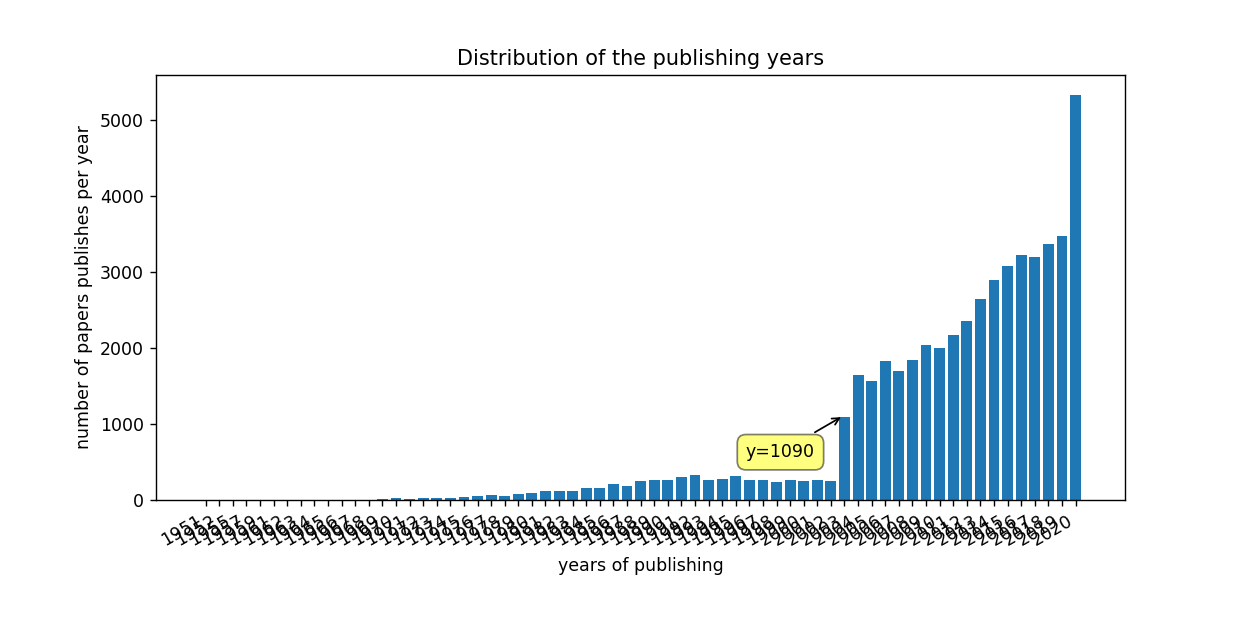

In [24]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of years of publishing")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

mplcursors.cursor(hover=True)

plt.show()

The distribution in the plot above shows that this data set is a broad collection of research papers and is most likely not restricted on the corona virus. We also see a first spike in the distribution around the time that SARS was descovered and another spike in the current year.  
In the analysis of the research topics of the data set we can get a better understanding on this distribution. 

## Topics
The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. In this section we inspect the topics of the research papers.  

The first plot shows a visualization of topics across the papers. 

<IPython.core.display.Javascript object>


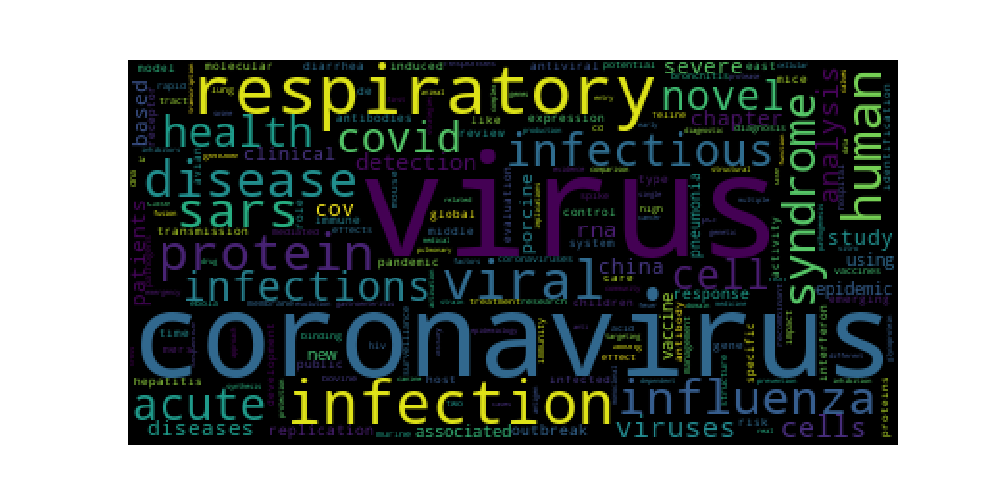

In [26]:
topics = []
for title in titles:
    topics.extend(preprocessing(title))

visualize_word_frequencies(topics)

The plot above emphesizes the different topics of the data set. As we can see the data set is not limited to papers about Coronavirus i.e. COVID-19 but contains papers about mutiple other viruses such as the influenza or SARS.  
To give a slight impression about the dataset we plot 20 random titles from the data set.

In [25]:
# Print random document titles
titles = get_dict_element_by_key('title')
titles_to_print = random.choices(titles, k=20)
print('\n'.join(titles_to_print))

Should this event be notified to the World Health Organization? Reliability of the International Health Regulations notification assessment process
Understanding the legal trade of cattle and camels and the derived risk of Rift Valley Fever introduction into and transmission within Egypt
Performance of the TB-LAMP diagnostic assay in reference laboratories: Results from a multicentre study
Different host cell proteases activate the SARS-coronavirus spike-protein for cell–cell and virus–cell fusion
Immunohistochemical studies on meningoencephalitis in feline infectious peritonitis (FIP)
Single-dose intranasal administration with mDEF201 (adenovirus vectored mouse interferon-alpha) confers protection from mortality in a lethal SARS-CoV BALB/c mouse model
Middle East Respiratory Syndrome (MERS) – An update
A review of the 2019 Novel Coronavirus (COVID-19) based on current evidence
Tat Peptide-Mediated Soluble Expression of the Membrane Protein LSECtin-CRD in Escherichia coli
Infections
Ba

Despite being only a tiny fraction of the data set that was plotted above, we can still see the broad range of topics that are being covered. 

In the next section we plot a clustering of the document titles. We use kMeans in combination with PCA to come up with a 2D representation of the topics. For indexing and comparing the titles we use a simple td-idf. 
Despite having more than 50'000 papers in the data base the collection of titles only still represents a relatively small data set. We therefore are not using a more sophisticated word emmbedding like Word2Vec. 

In [112]:
titles = np.array(get_dict_element_by_key('title'))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)

In [113]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

In [114]:
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

In [ ]:
labels = clustering_model.fit_predict(tfidf)
X = tfidf.todense()

In [ ]:
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

In [ ]:
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

## Visualize word frequencies
Visualize word frequencies of the abstracts to get a better insight in the topics covered in the papers.  
This plot visualizes the word frequencies across all abstracts. 

<IPython.core.display.Javascript object>


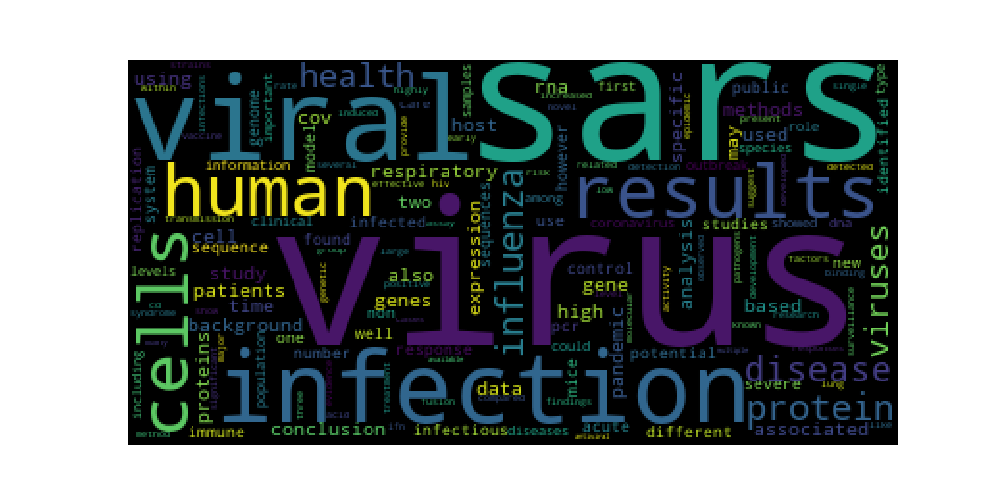

In [119]:
abstract_text = get_preprocessed_text_from_dict('abstract')

visualize_word_frequencies(chain(*abstract_text))

# Word2Vec
In this section we create Word2Vec models with the goal to extract usefull information from the papers. 

## Biorxiv data set
We train Word2Vec on the biorxiv data set only and explore som similarities of words in the data biorxiv data set. 

In [118]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=biorxiv_abstracts,
    window=10,
    min_count=2,
    workers=10)

In [120]:
biorxiv_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('promote', 0.9992626309394836),
 ('integral', 0.9988044500350952),
 ('toxin', 0.9987694025039673),
 ('ha', 0.9986975789070129),
 ('upon', 0.9984099864959717),
 ('biologically', 0.998376727104187),
 ('purifying', 0.9982712268829346),
 ('nsps', 0.9982655048370361),
 ('accumulation', 0.9982507228851318),
 ('lncrnas', 0.9982091188430786)]

In [121]:
biorxiv_model.most_similar('treatment')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fatal', 0.990588903427124),
 ('designated', 0.989082932472229),
 ('morbidity', 0.9888286590576172),
 ('prolonged', 0.986799955368042),
 ('middle', 0.9850047826766968),
 ('sfts', 0.9846419095993042),
 ('guillain', 0.9843944311141968),
 ('common', 0.9841051697731018),
 ('became', 0.984078586101532),
 ('gastroenteritis', 0.9832892417907715)]

We can see from the most similar words that the model did not really any usefull information. Not only are we not able to extract interesting information out of the biorxiv data set but 

## Train Word2Vec on all abstracts

In [ ]:
# collect all abstracts from the dictionary
dict_abstracts = get_preprocessed_sentences_from_dict('abstract')

# build vocabulary and train model for the biorxiv data set
word2Vec_model = Word2Vec(
    sentences=dict_abstracts,
    window=10,
    min_count=10,
    size=200,
    workers=10)

word2Vec_model.save('models/word2Vec_model')

In [95]:
# load the model from binary file
word2Vec_model = Word2Vec.load('models/word2Vec_model')

In [111]:
word2Vec_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('immune', 0.7022342681884766),
 ('immunities', 0.6643166542053223),
 ('responses', 0.640785813331604),
 ('defenses', 0.6326552629470825),
 ('humoral', 0.6120044589042664),
 ('tolerance', 0.5979035496711731),
 ('defences', 0.5802457332611084),
 ('defense', 0.564552903175354),
 ('immunopathology', 0.541820764541626),
 ('cmi', 0.5358951091766357)]

In [106]:
word2Vec_model.most_similar('corona')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('punta', 0.7001433372497559),
 ('norwalk', 0.698479413986206),
 ('nipah', 0.6981254816055298),
 ('toro', 0.6925269961357117),
 ('hendra', 0.6770345568656921),
 ('sindbis', 0.6566646695137024),
 ('berne', 0.65529465675354),
 ('arteritis', 0.6447701454162598),
 ('hantaan', 0.6374194622039795),
 ('teno', 0.6344308853149414)]

In [105]:
word2Vec_model.most_similar('covid')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ncov', 0.7239487767219543),
 ('ncp', 0.6462552547454834),
 ('wuhan', 0.5812234282493591),
 ('evd', 0.5234206914901733),
 ('ill', 0.4978787899017334),
 ('sars', 0.49548399448394775),
 ('situation', 0.4919361472129822),
 ('hubei', 0.48729461431503296),
 ('china', 0.43256276845932007),
 ('emergency', 0.43186184763908386)]

In [96]:
word2Vec_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('immune', 0.7022342681884766),
 ('immunities', 0.6643166542053223),
 ('responses', 0.640785813331604),
 ('defenses', 0.6326552629470825),
 ('humoral', 0.6120044589042664),
 ('tolerance', 0.5979035496711731),
 ('defences', 0.5802457332611084),
 ('defense', 0.564552903175354),
 ('immunopathology', 0.541820764541626),
 ('cmi', 0.5358951091766357)]

In [107]:
word2Vec_model.most_similar_cosmul(positive=['drug'], negative=['covid'])

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('cereus', 1.9729280471801758),
 ('microbicide', 1.8504582643508911),
 ('griffithsin', 1.8372138738632202),
 ('morpholino', 1.7866215705871582),
 ('cocktail', 1.7772520780563354),
 ('defensin', 1.7652896642684937),
 ('chitosan', 1.7622482776641846),
 ('bacteriophage', 1.757772445678711),
 ('pmo', 1.7332737445831299),
 ('pmos', 1.726317048072815)]

In [109]:
word2Vec_model.most_similar_cosmul(positive=['covid'], negative=['drug'])

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('wuhan', 1.7734811305999756),
 ('ncp', 1.7516103982925415),
 ('shanxi', 1.7411651611328125),
 ('hubei', 1.7199276685714722),
 ('riyadh', 1.7054667472839355),
 ('singapore', 1.695006251335144),
 ('jeddah', 1.6869397163391113),
 ('province', 1.67421293258667),
 ('toronto', 1.6398110389709473),
 ('beijing', 1.6331655979156494)]

## Update model with full text
Make use of the PDFs that contain the full text data and update the Word2Vec model.  
Save the updated model and load it from disk later.

In [ ]:
# update model with dody text

# collect all abstracts from the dictionary
dict_body_texts = get_preprocessed_sentences_from_dict('body_text')

# update the model using the body text
word2Vec_model.build_vocab(dict_body_texts, update=True)
word2Vec_model.train(more_sentences)

In [ ]:
# save updated Word2Vec as binary file
word2Vec_model.save('models/updated_word2Vec_model')

In [ ]:
# load the model from binary file
updated_word2Vec_model = Word2Vec.load('models/updated_word2Vec_model')

Compare some of the word similarities of the updated model to the original model that was only trained on the abstracts.

In [ ]:
word2Vec_model.most_similar('immunity')

## Embedding clustering

In [60]:
keys = ['covid', 'corona', 'immunity', 'disease', 'distancing', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2Vec_model.wv.most_similar(word, topn=15):
        words.append(similar_word)
        embeddings.append(word2Vec_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [61]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<IPython.core.display.Javascript object>


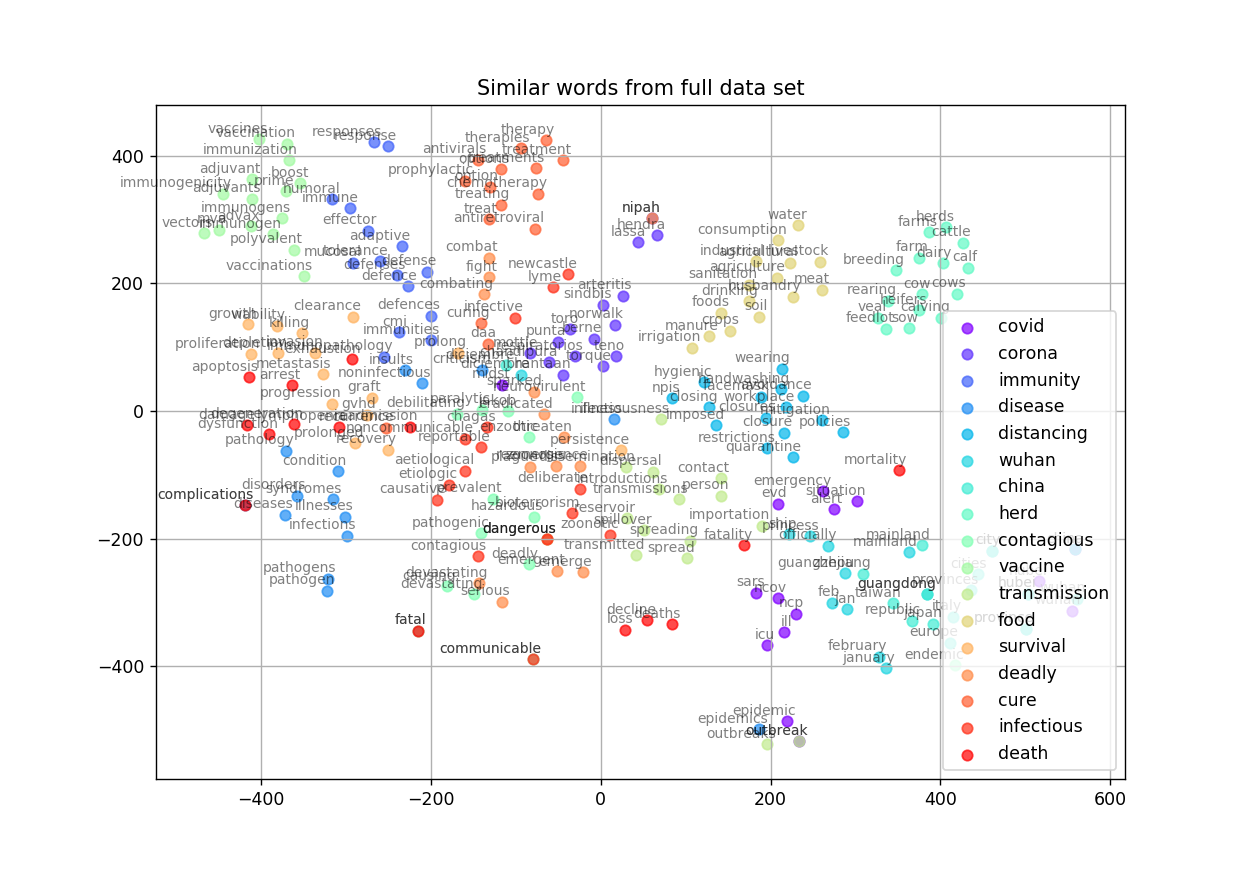

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [99]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(10,7))
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    
    mplcursors.cursor(hover=True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

    
tsne_plot_similar_words('Similar words from full data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

# Doc2Vec
Train a Doc2Vec model on the abstract of all papers.

In [67]:
# create documents
documents = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for key in paper_dict:
    abstract = paper_dict[key]['abstract']
    tags = [key]
    
    sentences = nltk.sent_tokenize(abstract)

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(analyzedDocument(preprocessed_sentences, tags))

# train the model
doc2Vec_model = doc2vec.Doc2Vec(documents, size=200, window=10, min_count=10, workers=10)

doc2Vec_model.save('models/doc2Vec_model')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
doc2Vec_model = Doc2Vec.load('models/doc2Vec_model')

## What is known about transmission, incubation, and environmental stability?

In [68]:
# query the model
query = "known about transmission, incubation, and environmental stability, CINVID-19".split()

query_vector = doc2Vec_model.infer_vector(query)
similar_abstracts = doc2Vec_model.docvecs.most_similar([query_vector])

for doc_tags in similar_abstracts:
    print(doc_tags[1])
    print_result_from_dict(doc_tags[0])

0.7603039741516113
Title: Viral Diversity, Prey Preference, and Bartonella Prevalence in Desmodus rotundus in Guatemala
Published on '2016-09-22' by 'Wray, Amy K.; Olival, Kevin J.; Morán, David; Lopez, Maria Renee; Alvarez, Danilo; Navarrete-Macias, Isamara; Liang, Eliza; Simmons, Nancy B.; Lipkin, W. Ian; Daszak, Peter; Anthony, Simon J.' in 'Ecohealth'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5164864/
Abstract: Certain bat species serve as natural reservoirs for pathogens in several key viral families including henipa-, lyssa-, corona-, and filoviruses, which may pose serious threats to human health. The Common Vampire Bat (Desmodus rotundus), due to its abundance, sanguivorous feeding habit involving humans and domestic animals, and highly social behavioral ecology, may have an unusually high potential for interspecies disease transmission. Previous studies have investigated rabies dynamics in D. rotundus, yet the diversity of other viruses, bacteria, and other microbes th

Abstract: Summary Background Characterisation of the severity profile of human infections with influenza viruses of animal origin is a part of pandemic risk assessment, and an important part of the assessment of disease epidemiology. Our objective was to assess the clinical severity of human infections with avian influenza A H7N9 virus, which emerged in China in early 2013. Methods We obtained information about laboratory-confirmed cases of avian influenza A H7N9 virus infection reported as of May 28, 2013, from an integrated database built by the Chinese Center for Disease Control and Prevention. We estimated the risk of fatality, mechanical ventilation, and admission to the intensive care unit for patients who required hospital admission for medical reasons. We also used information about laboratory-confirmed cases detected through sentinel influenza-like illness surveillance to estimate the symptomatic case fatality risk. Findings Of 123 patients with laboratory-confirmed avian infl

Abstract: Although human coronavirus OC43-OC43 (HCoV-OC43) is the coronavirus most commonly associated with human infections, little is known about its molecular epidemiology and evolution. We conducted a molecular epidemiology study to investigate different genotypes and potential recombination in HCoV-OC43. Twenty-nine HCoV-OC43 strains from nasopharyngeal aspirates, collected from 2004 to 2011, were subjected to RNA-dependent RNA polymerase (RdRp), spike, and nucleocapsid gene analysis. Phylogenetic analysis showed at least three distinct clusters of HCoV-OC43, although 10 unusual strains displayed incongruent phylogenetic positions between RdRp and spike genes. This suggested the presence of four HCoV-OC43 genotypes (A to D), with genotype D most likely arising from recombination. The complete genome sequencing of two genotype C and D strains and bootscan analysis showed recombination events between genotypes B and C in the generation of genotype D. Of the 29 strains, none belonged

# BM25 Index
Train a BM25 model on the abstract of all papers.

In [69]:
# create documents
documents = []
for key in paper_dict:
    abstract = paper_dict[key]['abstract']
    
    sentences = nltk.sent_tokenize(abstract)

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(preprocessed_sentences)

# train the model
bm25_model = BM25Okapi(documents)

# save model to binary file
save_obj(bm25_model, 'models/bm25_model')

In [ ]:
bm25_model = load_obj('models/bm25_model')

## What is known about transmission, incubation, and environmental stability?

In [70]:
def search(search_query, num_results=10):
    preprocessed_search_query = preprocessing(search_query)
    scores = bm25_model.get_scores(preprocessed_search_query)
    top_indexes = np.argsort(scores)[::-1][0:num_results]
    return top_indexes

In [71]:
query = "known about transmission, incubation, and environmental stability, CINVID-19"

top_indexes = search(query)
dict_keys = list(paper_dict.keys())
for index in top_indexes:
    dict_key = dict_keys[index]
    print_result_from_dict(dict_key)

Title: Chaos in a nonautonomous eco-epidemiological model with delay
Published on '2020-03-31' by 'Samanta, Sudip; Tiwari, Pankaj Kumar; Alzahrani, Abdullah K.; Alshomrani, Ali Saleh' in 'Applied Mathematical Modelling'
Url: https://doi.org/10.1016/j.apm.2019.11.006
Abstract: Abstract In this paper, we propose and analyze a nonautonomous predator-prey model with disease in prey, and a discrete time delay for the incubation period in disease transmission. Employing the theory of differential inequalities, we find sufficient conditions for the permanence of the system. Further, we use Lyapunov’s functional method to obtain sufficient conditions for global asymptotic stability of the system. We observe that the permanence of the system is unaffected due to presence of incubation delay. However, incubation delay affects the global stability of the positive periodic solution of the system. To reinforce the analytical results and to get more insight into the system’s behavior, we perform som

Abstract: Abstract Ras-GTPase-activating protein (SH3 domain)-binding proteins (G3BPs, also known as Rasputin) are a family of RNA binding proteins that regulate gene expression in response to environmental stresses by controlling mRNA stability and translation. G3BPs appear to facilitate this activity through their role in stress granules for which they are considered a core component, however, it should be noted that not all stress granules contain G3BPs and this appears to be contextual depending on the environmental stress and the cell type. Although the role of G3BPs in stress granules appears to be one of its major roles, data also strongly suggests that they interact with mRNAs outside of stress granules to regulate gene expression. G3BPs have been implicated in several diseases including cancer progression, invasion, and metastasis as well as virus survival. There is now a body of evidence that suggests targeting of G3BPs could be explored as a form of cancer therapeutic. This 

# Implement a BERT search engine 

Cred to Julien Heiduk (https://www.kaggle.com/zoupet/covid-19-search-engine-with-bert) for the initial idea of using a BERT search engine, which we plan to extend. 

In [0]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:20<00:00, 19.7MB/s]


In [0]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                  "How long can the 2019-nCoV virus remain viable on common surfaces?"
              ]
query_embeddings = model.encode(queries)

In [0]:
abstract_embeddings = model.encode(df_comm.text.values)

NameError: ignored

In [0]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity

closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(df_comm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
Porcine Epidemic Diarrhea Virus (PEDV), Porcine Delta Corona Virus (PDCoV), and Transmissible Gastroenteritis Virus (TGEV) are major threats to swine health and contaminated feed plays a role in virus transmission. The objective of our study was to characterize inactivation of PEDV, PDCoV, and TGEV in various feed ingredient matrices. Samples of complete feed, spray dried porcine plasma, meat meal, meat and bone meal, blood meal, corn, soybean meal, and corn dried distillers grains with solubles were weighed (5 g/sample) into scintillation vials and inoculated with 1 mL of PEDV, PDCoV, or TGEV. Samples were incubated at room temperature for up to 56 days. Aliquots were removed at various time points followed by preparing serial 10-fold dilutions and inoculating in cell cultures to determine the amount of surviving virus. Inactivation kinetics w

# Implement a BERT summarizer

In [0]:
from summarizer import Summarizer


In [0]:
body = '''
Those Who Are Resilient Stay In The Game Longer
“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.” — Friedrich Nietzsche
Challenges and setbacks are not meant to defeat you, but promote you. However, I realise after many years of defeats, it can crush your spirit and it is easier to give up than risk further setbacks and disappointments. Have you experienced this before? To be honest, I don’t have the answers. I can’t tell you what the right course of action is; only you will know. However, it’s important not to be discouraged by failure when pursuing a goal or a dream, since failure itself means different things to different people. To a person with a Fixed Mindset failure is a blow to their self-esteem, yet to a person with a Growth Mindset, it’s an opportunity to improve and find new ways to overcome their obstacles. Same failure, yet different responses. Who is right and who is wrong? Neither. Each person has a different mindset that decides their outcome. Those who are resilient stay in the game longer and draw on their inner means to succeed.
I’ve coached many clients who gave up after many years toiling away at their respective goal or dream. It was at that point their biggest breakthrough came. Perhaps all those years of perseverance finally paid off. It was the 19th Century’s minister Henry Ward Beecher who once said: “One’s best success comes after their greatest disappointments.” No one knows what the future holds, so your only guide is whether you can endure repeated defeats and disappointments and still pursue your dream. Consider the advice from the American academic and psychologist Angela Duckworth who writes in Grit: The Power of Passion and Perseverance: “Many of us, it seems, quit what we start far too early and far too often. Even more than the effort a gritty person puts in on a single day, what matters is that they wake up the next day, and the next, ready to get on that treadmill and keep going.”
I know one thing for certain: don’t settle for less than what you’re capable of, but strive for something bigger. Some of you reading this might identify with this message because it resonates with you on a deeper level. For others, at the end of their tether the message might be nothing more than a trivial pep talk. What I wish to convey irrespective of where you are in your journey is: NEVER settle for less. If you settle for less, you will receive less than you deserve and convince yourself you are justified to receive it.
“Two people on a precipice over Yosemite Valley” by Nathan Shipps on Unsplash
Develop A Powerful Vision Of What You Want
“Your problem is to bridge the gap which exists between where you are now and the goal you intend to reach.” — Earl Nightingale
I recall a passage my father often used growing up in 1990s: “Don’t tell me your problems unless you’ve spent weeks trying to solve them yourself.” That advice has echoed in my mind for decades and became my motivator. Don’t leave it to other people or outside circumstances to motivate you because you will be let down every time. It must come from within you. Gnaw away at your problems until you solve them or find a solution. Problems are not stop signs, they are advising you that more work is required to overcome them. Most times, problems help you gain a skill or develop the resources to succeed later. So embrace your challenges and develop the grit to push past them instead of retreat in resignation. Where are you settling in your life right now? Could you be you playing for bigger stakes than you are? Are you willing to play bigger even if it means repeated failures and setbacks? You should ask yourself these questions to decide whether you’re willing to put yourself on the line or settle for less. And that’s fine if you’re content to receive less, as long as you’re not regretful later.
If you have not achieved the success you deserve and are considering giving up, will you regret it in a few years or decades from now? Only you can answer that, but you should carve out time to discover your motivation for pursuing your goals. It’s a fact, if you don’t know what you want you’ll get what life hands you and it may not be in your best interest, affirms author Larry Weidel: “Winners know that if you don’t figure out what you want, you’ll get whatever life hands you.” The key is to develop a powerful vision of what you want and hold that image in your mind. Nurture it daily and give it life by taking purposeful action towards it.
Vision + desire + dedication + patience + daily action leads to astonishing success. Are you willing to commit to this way of life or jump ship at the first sign of failure? I’m amused when I read questions written by millennials on Quora who ask how they can become rich and famous or the next Elon Musk. Success is a fickle and long game with highs and lows. Similarly, there are no assurances even if you’re an overnight sensation, to sustain it for long, particularly if you don’t have the mental and emotional means to endure it. This means you must rely on the one true constant in your favour: your personal development. The more you grow, the more you gain in terms of financial resources, status, success — simple. If you leave it to outside conditions to dictate your circumstances, you are rolling the dice on your future.
So become intentional on what you want out of life. Commit to it. Nurture your dreams. Focus on your development and if you want to give up, know what’s involved before you take the plunge. Because I assure you, someone out there right now is working harder than you, reading more books, sleeping less and sacrificing all they have to realise their dreams and it may contest with yours. Don’t leave your dreams to chance.
''' 
model = Summarizer()
result = model(body, min_length=60)
full = ''.join(result)
print(full)

Those Who Are Resilient Stay In The Game Longer
“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.” I can’t tell you what the right course of action is; only you will know. Each person has a different mindset that decides their outcome. Those who are resilient stay in the game longer and draw on their inner means to succeed. No one knows what the future holds, so your only guide is whether you can endure repeated defeats and disappointments and still pursue your dream. “Two people on a precipice over Yosemite Valley” by Nathan Shipps on Unsplash
Develop A Powerful Vision Of What You Want
“Your problem is to bridge the gap which exists between where you are now and the goal you intend to reach.” Gnaw away at your problems until you solve them or find a solution. Nurture it daily and give it life by taking purposeful action towards it. Because I assur

# Search engine

In [74]:
# given a query:string
def search(query):
    query = query.lower()
    return query

In [75]:
print(search("Test BlOO"))

test bloo


## Search for documents for specific authors

In [222]:
def find_papers_by_authors(authors_query):
    keys = get_papers_by_authors(authors_query)
    for key in keys:
        print_result_from_dict(key)

In [223]:
find_papers_by_authors(['Chih-Fong'])

Title: Genetic lesions within the 3a gene of SARS-CoV
Published on '2005-06-20' by 'Tan, Timothy HP; Barkham, Timothy; Fielding, Burtram C; Chou, Chih-Fong; Shen, Shuo; Lim, Seng Gee; Hong, Wanjin; Tan, Yee-Joo' in 'Virol J'
Url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1183252/
Abstract: A series of frameshift mutations within the 3a gene has been observed in culture-derived severe acute respiratory syndrome coronavirus (SARS-CoV). We report here that viral RNA from clinical samples obtained from SARS-CoV infected patients also contains a heterogeneous population of wild-type and mutant 3a transcripts.




# Discussion 